In [1]:
import json 
import pandas as pd 
import numpy as np 
import time 
from datetime import timezone 
import os
from mplfinance.original_flavor import candlestick_ohlc
import pyupbit 
import ccxt
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from transformers import *
import os 
import time 
import datetime 
import matplotlib.pyplot as plt
from tqdm import tqdm 
import numpy as np
import json
from sklearn.model_selection import train_test_split
import seaborn as sns

PyTorch version 1.7.1 available.
TensorFlow version 2.5.0 available.
/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
btc_2019 = pd.read_csv("data_5m/2019_BTCUSDT.csv") 
btc_2020 = pd.read_csv("data_5m/2020_BTCUSDT.csv") 
btc_2021 = pd.read_csv("data_5m/2021_BTCUSDT.csv") 
btc_2022 = pd.read_csv("data_5m/2022_BTCUSDT.csv") 

eth_2019 = pd.read_csv("data_5m/2019_ETHUSDT.csv") 
eth_2020 = pd.read_csv("data_5m/2020_ETHUSDT.csv") 
eth_2021 = pd.read_csv("data_5m/2021_ETHUSDT.csv") 
eth_2022 = pd.read_csv("data_5m/2022_ETHUSDT.csv") 

btc_2019.shape, btc_2020.shape, btc_2021.shape, btc_2022.shape, eth_2019.shape, eth_2020.shape, eth_2021.shape, eth_2022.shape

((105291, 7),
 (105685, 7),
 (105448, 7),
 (11361, 7),
 (105291, 7),
 (105685, 7),
 (105448, 7),
 (11364, 7))

In [3]:
btc_train = pd.concat([btc_2019, btc_2020, btc_2021]) 
eth_train = pd.concat([eth_2019, eth_2020, eth_2021]) 

btc_val = btc_2022 
eth_val = eth_2022

btc_train.shape, eth_train.shape, btc_val.shape, eth_val.shape

((316424, 7), (316424, 7), (11361, 7), (11364, 7))

In [4]:
def process(df): 
    binance = ccxt.binance() 
    dates = df['Open Time'].values 
    timestamp = [] 
    for i in range(len(dates)): 
        date_string = binance.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df['datetime'] = timestamp 
    df = df.drop(columns={'0'})
    return df

In [5]:
btc_train = process(btc_train) 
eth_train = process(eth_train) 

btc_val = process(btc_val) 
eth_val = process(eth_val)

In [6]:
btc_train = btc_train.rename(columns={'Open':"BTC Open",
                                      'High':"BTC High", 
                                      'Low':"BTC Low",
                                      'Close':"BTC Close",
                                      'Volume':"BTC Volume"})

btc_train.head() 

,Open Time,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,datetime
0,1546300800000,3701.23,3703.72,3695.00,3696.32,85.572181,2019-01-01 00:00:00
1,1546301100000,3696.30,3697.24,3689.88,3692.34,62.296581,2019-01-01 00:05:00
2,1546301400000,3692.34,3698.93,3692.34,3697.31,43.105333,2019-01-01 00:10:00
3,1546301700000,3697.91,3698.75,3693.00,3693.00,48.551084,2019-01-01 00:15:00
4,1546302000000,3693.44,3695.98,3690.92,3692.18,47.706443,2019-01-01 00:20:00


In [7]:
eth_train = eth_train.rename(columns={'Open':"ETH Open",
                                      'High':"ETH High", 
                                      'Low':"ETH Low",
                                      'Close':"ETH Close",
                                      'Volume':"ETH Volume"})

eth_train.head()

,Open Time,ETH Open,ETH High,ETH Low,ETH Close,ETH Volume,datetime
0,1546300800000,131.45,131.54,131.01,131.27,1269.12705,2019-01-01 00:00:00
1,1546301100000,131.26,131.35,131.12,131.29,1601.91843,2019-01-01 00:05:00
2,1546301400000,131.27,131.36,131.19,131.31,560.54337,2019-01-01 00:10:00
3,1546301700000,131.30,131.36,131.25,131.30,651.89505,2019-01-01 00:15:00
4,1546302000000,131.26,131.44,131.25,131.28,500.58218,2019-01-01 00:20:00


In [8]:
btc_train = btc_train.drop(columns={'Open Time'}) 
eth_train = eth_train.drop(columns={'Open Time'})
full_df = btc_train.join(eth_train.set_index('datetime'), on='datetime') 

In [9]:
full_df = full_df.dropna() 
full_df.head()

,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,datetime,ETH Open,ETH High,ETH Low,ETH Close,ETH Volume
0,3701.23,3703.72,3695.00,3696.32,85.572181,2019-01-01 00:00:00,131.45,131.54,131.01,131.27,1269.12705
1,3696.30,3697.24,3689.88,3692.34,62.296581,2019-01-01 00:05:00,131.26,131.35,131.12,131.29,1601.91843
2,3692.34,3698.93,3692.34,3697.31,43.105333,2019-01-01 00:10:00,131.27,131.36,131.19,131.31,560.54337
3,3697.91,3698.75,3693.00,3693.00,48.551084,2019-01-01 00:15:00,131.30,131.36,131.25,131.30,651.89505
4,3693.44,3695.98,3690.92,3692.18,47.706443,2019-01-01 00:20:00,131.26,131.44,131.25,131.28,500.58218


In [10]:
minutes = [] 
hours = []
days = [] 
months = [] 
for dt in tqdm(full_df['datetime']):
    minute = pd.to_datetime(dt).minute
    hour = pd.to_datetime(dt).hour 
    day = pd.to_datetime(dt).day 
    month = pd.to_datetime(dt).month 
    minutes.append(minute)
    hours.append(hour) 
    days.append(day) 
    months.append(month)
    
full_df['Minutes'] = minutes
full_df['Hours'] = hours
full_df['Days'] = days 
full_df['Months'] = months 

100%|██████████| 319572/319572 [02:41<00:00, 1976.22it/s]


In [11]:
full_df = full_df.drop(columns={'datetime'}) 
full_df.head()

,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,ETH Open,ETH High,ETH Low,ETH Close,ETH Volume,Minutes,Hours,Days,Months
0,3701.23,3703.72,3695.00,3696.32,85.572181,131.45,131.54,131.01,131.27,1269.12705,0,0,1,1
1,3696.30,3697.24,3689.88,3692.34,62.296581,131.26,131.35,131.12,131.29,1601.91843,5,0,1,1
2,3692.34,3698.93,3692.34,3697.31,43.105333,131.27,131.36,131.19,131.31,560.54337,10,0,1,1
3,3697.91,3698.75,3693.00,3693.00,48.551084,131.30,131.36,131.25,131.30,651.89505,15,0,1,1
4,3693.44,3695.98,3690.92,3692.18,47.706443,131.26,131.44,131.25,131.28,500.58218,20,0,1,1


In [12]:
N = 30 # lookback window 
K = 6 # future timestamp 

In [13]:
btc_val = btc_val.drop(columns={'Open Time'}) 
eth_val = eth_val.drop(columns={'Open Time'})

In [14]:
btc_val = btc_val.rename(columns={'Open':"BTC Open",
                                      'High':"BTC High", 
                                      'Low':"BTC Low",
                                      'Close':"BTC Close",
                                      'Volume':"BTC Volume"})

eth_val = eth_val.rename(columns={'Open':"ETH Open",
                                      'High':"ETH High", 
                                      'Low':"ETH Low",
                                      'Close':"ETH Close",
                                      'Volume':"ETH Volume"})

full_val = btc_val.join(eth_val.set_index('datetime'), on='datetime')  


In [15]:
minutes = [] 
hours = []
days = [] 
months = [] 
for dt in tqdm(full_val['datetime']):
    minute = pd.to_datetime(dt).minute
    hour = pd.to_datetime(dt).hour 
    day = pd.to_datetime(dt).day 
    month = pd.to_datetime(dt).month 
    minutes.append(minute)
    hours.append(hour) 
    days.append(day) 
    months.append(month)
    
full_val['Minutes'] = minutes
full_val['Hours'] = hours
full_val['Days'] = days 
full_val['Months'] = months 

100%|██████████| 11473/11473 [00:05<00:00, 1981.01it/s]


In [16]:
full_val = full_val.drop(columns={'datetime'}) 
full_val.head()

,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,ETH Open,ETH High,ETH Low,ETH Close,ETH Volume,Minutes,Hours,Days,Months
0,46216.93,46391.49,46208.37,46321.34,185.67558,3676.22,3695.41,3676.22,3690.09,1363.4570,0,0,1,1
1,46321.34,46527.26,46280.00,46371.11,123.43577,3690.12,3705.90,3686.70,3696.55,862.5494,5,0,1,1
2,46369.79,46394.00,46276.22,46332.51,77.54574,3696.55,3699.81,3686.70,3691.90,753.5524,10,0,1,1
3,46332.52,46332.52,46236.27,46293.90,101.14315,3691.90,3693.35,3685.83,3689.51,438.4134,15,0,1,1
4,46295.42,46421.27,46286.25,46395.53,135.32479,3689.51,3699.58,3688.60,3699.45,372.5966,20,0,1,1


# Data Normalization

In [17]:
BTC_OHLC_COLS = ["BTC Open", "BTC High", "BTC Low", "BTC Close"] 
BTC_VOL = ["BTC Volume"] 

ETH_OHLC_COLS = ["ETH Open", "ETH High", "ETH Low", "ETH Close"] 
ETH_VOL = ["ETH Volume"] 

BTC_OHLC_NORM = full_df[BTC_OHLC_COLS].copy() 
BTC_VOL_NORM = full_df[BTC_VOL].copy() 

ETH_OHLC_NORM = full_df[ETH_OHLC_COLS].copy() 
ETH_VOL_NORM = full_df[ETH_VOL].copy() 

full_df[BTC_OHLC_COLS] = (full_df[BTC_OHLC_COLS]-BTC_OHLC_NORM.stack().mean()) / BTC_OHLC_NORM.stack().std() 
full_df[BTC_VOL] = (full_df[BTC_VOL]-BTC_VOL_NORM.stack().mean()) / BTC_VOL_NORM.stack().std() 

full_df[ETH_OHLC_COLS] = (full_df[ETH_OHLC_COLS]-ETH_OHLC_NORM.stack().mean()) / ETH_OHLC_NORM.stack().std() 
full_df[ETH_VOL] = (full_df[ETH_VOL]-ETH_VOL_NORM.stack().mean()) / ETH_VOL_NORM.stack().std() 


full_df.head()

,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,ETH Open,ETH High,ETH Low,ETH Close,ETH Volume,Minutes,Hours,Days,Months
0,-0.952481,-0.952351,-0.952807,-0.952738,-0.475917,-0.715044,-0.714977,-0.715374,-0.715179,-0.364247,0,0,1,1
1,-0.952739,-0.952690,-0.953075,-0.952946,-0.563707,-0.715187,-0.715119,-0.715292,-0.715164,-0.264504,5,0,1,1
2,-0.952946,-0.952602,-0.952946,-0.952686,-0.636092,-0.715179,-0.715112,-0.715239,-0.715149,-0.576623,10,0,1,1
3,-0.952655,-0.952611,-0.952912,-0.952912,-0.615552,-0.715157,-0.715112,-0.715194,-0.715157,-0.549243,15,0,1,1
4,-0.952889,-0.952756,-0.953020,-0.952954,-0.618737,-0.715187,-0.715052,-0.715194,-0.715172,-0.594594,20,0,1,1


In [18]:
full_val[BTC_OHLC_COLS] = (full_val[BTC_OHLC_COLS]-BTC_OHLC_NORM.stack().mean()) / BTC_OHLC_NORM.stack().std() 
full_val[BTC_VOL] = (full_val[BTC_VOL]-BTC_VOL_NORM.stack().mean()) / BTC_VOL_NORM.stack().std() 

full_val[ETH_OHLC_COLS] = (full_val[ETH_OHLC_COLS]-ETH_OHLC_NORM.stack().mean()) / ETH_OHLC_NORM.stack().std() 
full_val[ETH_VOL] = (full_val[ETH_VOL]-ETH_VOL_NORM.stack().mean()) / ETH_VOL_NORM.stack().std() 

full_val.head()

,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,ETH Open,ETH High,ETH Low,ETH Close,ETH Volume,Minutes,Hours,Days,Months
0,1.269664,1.278787,1.269216,1.275121,-0.098350,1.941060,1.955439,1.941060,1.951453,-0.335975,0,0,1,1
1,1.275121,1.285883,1.272960,1.277722,-0.333104,1.951475,1.963299,1.948913,1.956293,-0.486106,5,0,1,1
2,1.277653,1.278918,1.272762,1.275705,-0.506191,1.956293,1.958736,1.948913,1.952809,-0.518775,10,0,1,1
3,1.275705,1.275705,1.270674,1.273686,-0.417187,1.952809,1.953895,1.948261,1.951018,-0.613227,15,0,1,1
4,1.273766,1.280344,1.273287,1.278998,-0.288262,1.951018,1.958564,1.950336,1.958466,-0.632954,20,0,1,1


In [28]:
con_cols = ["BTC Open", "BTC High", "BTC Low", "BTC Close", "BTC Volume",
            "ETH Open", "ETH High", "ETH Low", "ETH Close", "ETH Volume"] 
disc_cols = ["Hours"]

features = 10 

train_cont = full_df[con_cols].values 
train_disc = full_df[disc_cols].values

val_cont = full_val[con_cols].values 
val_disc = full_val[disc_cols].values 

train_in_cont, train_target_seq = [], []  
train_in_disc, train_future_disc = [], []  

for i in tqdm(range(train_cont.shape[0]-N-K), position=0, leave=True): 
    in_cont = train_cont[i:i+N,:] 
    in_disc = train_disc[i:i+N,:] 
    target = train_cont[i+N+K,3] # predict close 
    future_disc = train_disc[i+N+K,:]  
    
    train_in_cont.append(in_cont) 
    train_target_seq.append(target)
    train_in_disc.append(in_disc) 
    train_future_disc.append(future_disc) 


    
val_in_cont, val_target_seq = [], []  
val_in_disc, val_future_disc = [], []  

for i in tqdm(range(val_cont.shape[0]-N-K), position=0, leave=True): 
    in_cont = val_cont[i:i+N,:] 
    in_disc = val_disc[i:i+N,:] 
    target = val_cont[i+N+K,3] 
    future_disc = val_disc[i+N+K,:]  
    
    val_in_cont.append(in_cont) 
    val_target_seq.append(target)
    val_in_disc.append(in_disc) 
    val_future_disc.append(future_disc) 

train_in_cont = torch.tensor(train_in_cont, dtype=torch.float32) 
train_in_cont = torch.reshape(train_in_cont, (-1,N,features,1)) 
train_target_seq = torch.tensor(train_target_seq, dtype=torch.float32) 
train_target_seq = torch.reshape(train_target_seq, (-1,1))  


val_in_cont = torch.tensor(val_in_cont, dtype=torch.float32) 
val_in_cont = torch.reshape(val_in_cont, (-1,N,features,1))
val_target_seq = torch.tensor(val_target_seq, dtype=torch.float32) 
val_target_seq = torch.reshape(val_target_seq, (-1,1)) 

train_in_cont.shape, train_target_seq.shape, val_in_cont.shape, val_target_seq.shape

100%|██████████| 11437/11437 [00:00<00:00, 318417.64it/s]


(torch.Size([319536, 30, 10, 1]),
 torch.Size([319536, 1]),
 torch.Size([11437, 30, 10, 1]),
 torch.Size([11437, 1]))

In [30]:
def one_hot(x, dims, gpu = True):
    out = []
    batch_size = x.shape[0]
    seq_len = x.shape[1]
    
    if(not gpu):
        dtype = torch.FloatTensor
    else:
        dtype = torch.cuda.FloatTensor
        
    for i in tqdm(range(0, x.shape[-1])):
        x_ = x[:,:,i].byte().cpu().long().unsqueeze(-1)
        o = torch.zeros([batch_size, seq_len, dims[i]]).long()

        o.scatter_(-1, x_,  1)
        out.append(o.type(dtype))
    return out

In [31]:
train_in_disc = torch.tensor(train_in_disc, dtype=torch.float32)
train_in_disc = one_hot(train_in_disc, dims=[24]) 
train_in_disc = train_in_disc[0] 

train_in_disc.shape

100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


torch.Size([319536, 30, 24])

In [32]:
train_future_disc = torch.tensor(train_future_disc, dtype=torch.float32) 
train_future_disc = torch.reshape(train_future_disc, (-1,1,1))
train_future_disc = one_hot(train_future_disc, dims=[24]) 
train_future_disc = train_future_disc[0] 

train_future_disc.shape 

100%|██████████| 1/1 [00:00<00:00, 52.74it/s]


torch.Size([319536, 1, 24])

In [33]:
val_in_disc = torch.tensor(val_in_disc, dtype=torch.float32)
val_in_disc = one_hot(val_in_disc, dims=[24]) 
val_in_disc = val_in_disc[0] 

val_in_disc.shape

100%|██████████| 1/1 [00:00<00:00, 26.76it/s]


torch.Size([11437, 30, 24])

In [34]:
val_future_disc = torch.tensor(val_future_disc, dtype=torch.float32) 
val_future_disc = torch.reshape(val_future_disc, (-1,1,1))
val_future_disc = one_hot(val_future_disc, dims=[24]) 
val_future_disc = val_future_disc[0] 

val_future_disc.shape 

100%|██████████| 1/1 [00:00<00:00, 87.86it/s]


torch.Size([11437, 1, 24])

In [35]:
train_in_disc = torch.reshape(train_in_disc, (-1, 30, 1, 24)) 
train_future_disc = torch.reshape(train_future_disc, (-1, 1, 1, 24)) 

val_in_disc = torch.reshape(val_in_disc, (-1,30,1,24)) 
val_future_disc = torch.reshape(val_future_disc, (-1, 1, 1, 24))

In [36]:
val_future_disc.shape

torch.Size([11437, 1, 1, 24])

# Define Temporal Fusion Transformer

In [37]:
def a_norm(Q, K): 
    m = torch.matmul(Q, K.transpose(2,1).float()) 
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float()) 
    return torch.softmax(m, -1) 

def attention(Q, K, V): 
    a = a_norm(Q, K) # (batch_size, dim_attn, seq_length) 
    return torch.matmul(a, V) # (batch_size, seq_length, seq_length) 

class AttentionBlock(torch.nn.Module): 
    def __init__(self, dim_val, dim_attn): 
        super(AttentionBlock, self).__init__()
        self.value = Value(dim_val, dim_val) 
        self.key = Key(dim_val, dim_attn) 
        self.query = Query(dim_val, dim_attn) 
    
    def forward(self, x, kv = None):
        if kv is None:
            # Attention with x connected to Q,K and V (For encoder)
            return attention(self.query(x), self.key(x), self.value(x))
        # Attention with x as Q, external vector kv as K and V (For decoder)
        return attention(self.query(x), self.key(kv), self.value(kv))
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, dim_attn))
        
        self.fc = nn.Linear(n_heads * dim_val, dim_val, bias = False)
                      
    def forward(self, x, kv = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv))
            
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs
        
        x = self.fc(a)
        return x
    
class Value(torch.nn.Module):
    def __init__(self, dim_input, dim_val):
        super(Value, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_val, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

class Key(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Key, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

class Query(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Query, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

def QuantileLoss(net_out, Y, q):
    return (q * F.relu(net_out - Y)) + ((1 - q) * F.relu(Y - net_out))


In [38]:
class GLU(torch.nn.Module):
    def __init__(self, dim_input):
        super(GLU, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_input)
        self.fc2 = nn.Linear(dim_input, dim_input)
    
    def forward(self, x):
        return torch.sigmoid(self.fc1(x)) * self.fc2(x) 

In [39]:
class GRN(torch.nn.Module): 
    def __init__(self, dim_input, dim_out=None, n_hidden=10, dropout_r=0.1):
        super(GRN, self).__init__() 
        if dim_out != None: 
            self.skip = nn.Linear(dim_input, dim_out) 
        else:
            self.skip = None
            dim_out = dim_input 
        self.fc1 = nn.Linear(dim_input, n_hidden) 
        self.fc2 = nn.Linear(n_hidden, dim_out) 
        self.dropout = nn.Dropout(dropout_r) 
        self.gate = GLU(dim_out) 
        self.norm = nn.LayerNorm(dim_out) 
        
    def forward(self, x):
        a = F.elu(self.fc1(x))
        a = self.dropout(self.fc2(a))
        a = self.gate(a)
        if self.skip != None:
            return self.norm(self.skip(x) + a)
        return self.norm(x + a)

In [40]:
class VSN(torch.nn.Module): 
    def __init__(self, n_var_cont, n_var_disc, dim_model, dropout_r=0.1): 
        super(VSN, self).__init__()
        n_var_total = n_var_cont + len(n_var_disc)
        # linear transformation of inputs into dmodel vectors 
        self.linearise = []
        for i in range(n_var_cont): 
            self.linearise.append(nn.Linear(1, dim_model, bias=False).cuda()) 
        
        self.fc = nn.Linear(1, dim_model, bias=False).cuda()     
        # entity embeddings for discrete inputs 
        self.entity_embed = [] 
        for i in n_var_disc: 
            self.entity_embed.append(nn.Linear(i, dim_model, bias=False).cuda())  
        
        self.input_grn = GRN(dim_model, dropout_r = dropout_r) 
        self.vs_grn = GRN(n_var_total * dim_model, dim_out=n_var_total, dropout_r = dropout_r)
    
    # input (batch_size, seq_len, n_variables, input_size)
    def forward(self, x_cont, x_disc): 
        # linearise continuous inputs 
        linearised = [] 
        for idx, fc in enumerate(self.linearise): 
            linearised.append(fc(x_cont[:,:,idx])) 
        # entity embeddings for discrete inputs 
        embedded = []
        for idx, fc in enumerate(self.entity_embed): 
            embedded.append(fc(x_disc[:,:,idx]))
        '''
        for x, fc in zip(x_disc, self.entity_embed): 
            embedded.append(fc(x)) 
        '''
        if len(self.linearise) != 0 and len(self.entity_embed) != 0: 
            linearised = torch.stack(linearised, dim=-2) 
            embedded = torch.stack(embedded, dim=-2)    
            vectorised_vars = torch.cat((linearised, embedded), dim=-2) # (batch_size, seq_len, dim_model, n_vars_total)
        elif len(self.linearise) != 0 and len(self.entity_embed) == 0: 
            vectorised_vars = torch.stack(linearised, dim=-2) # (batch_size, seq_len, n_var_cont, dim_model)
        elif len(self.entity_embed) != 0 and len(self.linearise) == 0: 
            vectorised_vars = torch.stack(embedded, dim=-2)
        
        # flatten everything except accross batch for variable selection weights 
        vs_weights = self.vs_grn(vectorised_vars.flatten(start_dim=2)) # (batch_size, seq_len, n_variables)
        vs_weights = torch.softmax(vs_weights, dim=-1).unsqueeze(-1) # (batch_size, seq_len, n_variables, 1) 
        
        # input_grn applied to every input separately 
        input_weights = self.input_grn(vectorised_vars) # (batch_size, seq_len, n_variables, dim_model)
        
        x = torch.sum((vs_weights * input_weights), dim = 2) 
        return x, vs_weights # returns (batch_size, seq_len, dim_model)
        

In [41]:
class LSTMLayer(torch.nn.Module): 
    def __init__(self, dim_model, n_layers = 1, dropout_r = 0.1):
        super(LSTMLayer, self).__init__()
        self.n_layers = n_layers 
        self.dim_model = dim_model 
        self.lstm = nn.LSTM(dim_model, dim_model, num_layers = n_layers, batch_first = True) 
        self.hidden = None
        self.dropout = nn.Dropout(dropout_r) 
    
    # takes input (batch_size, seq_len, dim_model)
    def forward(self, x): 
        if self.hidden == None: 
            raise Exception("Call reset() to initialise LSTM Layer") 
            
        x, self.hidden = self.lstm(x, self.hidden) 
        x = self.dropout(x) 
        return x, self.hidden # returns (batch_size, seq_len, dim_model), hidden 
    
    def reset(self, batch_size, gpu = True): 
        if not gpu: 
            dtype = torch.FloatTensor 
        else: 
            dtype = torch.cuda.FloatTensor
        self.hidden = (torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype),
                       torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype)) 

In [47]:
class TFN(torch.nn.Module): 
    def __init__(self, 
                 n_var_past_cont, 
                 n_var_future_cont,
                 n_var_past_disc, 
                 n_var_future_disc,
                 dim_model,
                 n_quantiles = 1, 
                 dropout_r = 0.1,
                 n_lstm_layers = 1,
                 n_attention_layers = 1,
                 n_heads = 4):
        super(TFN, self).__init__()
        self.vs_past = VSN(n_var_past_cont, n_var_past_disc, dim_model, dropout_r = dropout_r) 
        self.vs_future = VSN(n_var_future_cont, n_var_future_disc, dim_model, dropout_r = dropout_r)
        
        self.enc = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers) 
        self.dec = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers) 
        
        self.gate1 = GLU(dim_model) 
        self.norm1 = nn.LayerNorm(dim_model) 
        
        self.static_enrich_grn = GRN(dim_model, dropout_r = dropout_r)
        
        self.attention = [] 
        for i in range(n_attention_layers): 
            self.attention.append([MultiHeadAttentionBlock(dim_model, dim_model, n_heads = n_heads).cuda(),
                                   nn.LayerNorm(dim_model).cuda()]) 
        
        self.norm2 = nn.LayerNorm(dim_model) 
        self.positionwise_grn = GRN(dim_model, dropout_r = dropout_r) 
        self.norm3 = nn.LayerNorm(dim_model) 
        self.dropout = nn.Dropout(dropout_r) 
        self.fc_out = nn.Linear(dim_model, n_quantiles) 
        
    # takes input (batch_size, past_seq_len, n_variables_past) 
    # and (batch_size, future_seq_len, n_variables_future) 
    def forward(self, x_past_cont, x_past_disc, x_future_cont, x_future_disc):
        # Encoder 
        x_past, vs_weights = self.vs_past(x_past_cont, x_past_disc) 
        e, e_hidden = self.enc(x_past) 
        self.dec_hidden = e_hidden 
        e = self.dropout(e) 
        x_past = self.norm1(self.gate1(e) + x_past) 

        # Decoder
        x_future, _ = self.vs_future(x_future_cont, x_future_disc) 
        d, _ = self.dec(x_future) 
        d = self.dropout(d) 
        x_future = self.norm1(self.gate1(d) + x_future) 

        # static enrichment
        x = torch.cat((x_past, x_future), dim=1) # (batch_size, past_seq_len + future_seq_len, dim_model)
        attention_res = x_future
        x = self.static_enrich_grn(x) 

        # attention layer 
        a = self.attention[0][1](self.attention[0][0](x) + x) 
        for at in self.attention[1:]:
            a = at[1](at[0](a) + a) 
        x_future = self.norm2(a[:, x_past.shape[1]:] + x_future) 
        a = self.positionwise_grn(x_future) 
        x_future = self.norm3(a + x_future + attention_res) 
        net_out = self.fc_out(x_future)  
        return net_out, vs_weights 

    def reset(self, batch_size, gpu = True): 
        self.enc.reset(batch_size, gpu) 
        self.dec.reset(batch_size, gpu) 

In [48]:
class CustomDataset(Dataset): 
    def __init__(self, past_cont, past_disc, target_seq, future_disc): 
        self.past_cont = past_cont
        self.past_disc = past_disc 
        self.target_seq = target_seq  
        self.future_disc = future_disc 
        
    def __len__(self): 
        return len(self.past_cont) 
    
    def __getitem__(self, i):  
        return {
            'past_cont': torch.tensor(self.past_cont[i], dtype=torch.float32), 
            'past_disc': torch.tensor(self.past_disc[i], dtype=torch.float32), 
            'target_seq': torch.tensor(self.target_seq[i], dtype=torch.float32),  
            'future_disc': torch.tensor(self.future_disc[i], dtype=torch.float32),  
        }

In [49]:
BATCH_SIZE = 128

train_dataset = CustomDataset(train_in_cont, train_in_disc, train_target_seq, train_future_disc)
val_dataset = CustomDataset(val_in_cont, val_in_disc, val_target_seq, val_future_disc)  

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True) 
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False) 


In [50]:
model = TFN(n_var_past_cont = 10,
            n_var_future_cont = 0, 
            n_var_past_disc = [24],
            n_var_future_disc = [24],
            dim_model = 160) 

model.cuda()


TFN(
  (vs_past): VSN(
    (fc): Linear(in_features=1, out_features=160, bias=False)
    (input_grn): GRN(
      (fc1): Linear(in_features=160, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=160, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=160, out_features=160, bias=True)
        (fc2): Linear(in_features=160, out_features=160, bias=True)
      )
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (vs_grn): GRN(
      (skip): Linear(in_features=1760, out_features=11, bias=True)
      (fc1): Linear(in_features=1760, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=11, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=11, out_features=11, bias=True)
        (fc2): Linear(in_features=11, out_features=11, bias=True)
      )
      (norm): LayerNorm((11,), eps=1e-05, elementwise_aff

In [64]:
device = torch.device('cuda')

quantiles = torch.tensor([0.1, 0.5, 0.9]).float().type(torch.cuda.FloatTensor)

epochs = 50

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5) 

train_losses, val_losses = [], []  

criterion = nn.MSELoss()

In [67]:
def evaluate(data_dataloader): 
    eval_loss = 0 
    for step, batch in enumerate(data_dataloader): 
        past_cont = batch['past_cont'].to(device) 
        past_disc = batch['past_disc'].to(device) 
        target_seq = batch['target_seq'].to(device) 
        future_disc = batch['future_disc'].to(device) 
        
        model.reset(batch_size=past_cont.shape[0], gpu=True)

        
        with torch.no_grad():
            net_out, vs_weights = model(x_past_cont = past_cont, 
                                        x_past_disc = past_disc,
                                        x_future_cont = None, 
                                        x_future_disc = future_disc) 
        
        # loss = torch.mean(QuantileLoss(net_out, target_seq, quantiles)) 
        loss = criterion(net_out, target_seq)
        eval_loss += loss.item() 
    
    avg_val_loss = eval_loss / len(data_dataloader)
        
    return avg_val_loss, net_out, vs_weights

In [68]:
# plot figures every epoch 
fig = plt.figure()
ax = fig.add_subplot(411)
ax1 = fig.add_subplot(412)
# ax2 = fig.add_subplot(413)
ax3 = fig.add_subplot(414)
plt.ion()


for i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(i + 1, epochs))
    print('Training...')
    total_loss = 0 
    model.train() 
    
    for step, batch in tqdm(enumerate(train_dataloader)): 
        if step%200 == 0 and not step == 0: 
            model.eval() 
            val_loss, _, _ = evaluate(val_dataloader) 
            val_losses.append(val_loss) 
            if np.min(val_losses) == val_losses[-1]: 
                print("saving best checkpoint!") 
                torch.save(model.state_dict(), "TFT_binance_prototype.pt") 
            model.train()  
    
        
        past_cont = batch['past_cont'].to(device) 
        past_disc = batch['past_disc'].to(device) 
        target_seq = batch['target_seq'].to(device) 
        future_disc = batch['future_disc'].to(device) 
        model.reset(batch_size=past_cont.shape[0], gpu=True)
                
        optimizer.zero_grad() 

        net_out, vs_weights = model(x_past_cont = past_cont, 
                                    x_past_disc = past_disc, 
                                    x_future_cont = None, 
                                    x_future_disc = future_disc) 
        
        # net_out = net_out.cpu().detach()[0]
        #loss = torch.mean(QuantileLoss(net_out, target_seq, quantiles))  
        net_out = torch.reshape(net_out, (-1,1))
        loss = criterion(net_out, target_seq)
        # backward pass 
        train_losses.append(loss.item()) 
        loss.backward() 
        optimizer.step() 

        # loss graphs
        fig.tight_layout(pad=0.1) 
        ax.clear()
        ax.title.set_text("Training Loss")
        ax.plot(train_losses)
        
        ax1.clear() 
        ax1.title.set_text("Val Loss")
        ax1.plot(val_losses) 
        
        # visualise variable selection weights 
        vs_weights = torch.mean(torch.mean(vs_weights, dim=0), dim=0).squeeze()  
        vs_weights = vs_weights.cpu().detach().numpy()
        ax3.clear() 
        ax3.title.set_text("Variable Selection Weights") 
        plt.xticks(rotation=-30) 
        x = ["BTC Open", "BTC High", "BTC Low", "BTC Close", "BTC Volume",
            "ETH Open", "ETH High", "ETH Low", "ETH Close", "ETH Volume", "Hours"] 
        ax3.bar(x=x, height=vs_weights) 
        fig.canvas.draw() 


======== Epoch 1 / 50 ========
Training...


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use s

saving best checkpoint!


400it [02:15,  3.04it/s]

saving best checkpoint!


600it [03:23,  2.90it/s]

saving best checkpoint!


800it [04:34,  3.02it/s]

saving best checkpoint!


1000it [05:41,  3.01it/s]

saving best checkpoint!


1200it [06:53,  2.64it/s]

saving best checkpoint!


1400it [08:02,  2.96it/s]

saving best checkpoint!


1600it [09:10,  3.06it/s]

saving best checkpoint!


1800it [10:21,  2.88it/s]

saving best checkpoint!


2000it [11:32,  3.27it/s]

saving best checkpoint!


2200it [12:39,  3.17it/s]

saving best checkpoint!


2497it [14:22,  2.90it/s]



======== Epoch 2 / 50 ========
Training...


200it [01:06,  2.49it/s]

saving best checkpoint!


1000it [05:44,  3.10it/s]

saving best checkpoint!


1200it [06:54,  2.75it/s]

saving best checkpoint!


2497it [14:23,  2.89it/s]



======== Epoch 3 / 50 ========
Training...


200it [01:05,  3.64it/s]

saving best checkpoint!


600it [03:21,  2.86it/s]

saving best checkpoint!


2497it [14:23,  2.89it/s]



======== Epoch 4 / 50 ========
Training...


800it [04:38,  3.02it/s]

saving best checkpoint!


1400it [08:05,  2.74it/s]

saving best checkpoint!


1800it [10:13,  3.18it/s]

saving best checkpoint!


2497it [14:01,  2.97it/s]



======== Epoch 5 / 50 ========
Training...


2497it [15:01,  2.77it/s]



======== Epoch 27 / 50 ========
Training...


2497it [15:05,  2.76it/s]



======== Epoch 28 / 50 ========
Training...


2497it [15:09,  2.75it/s]



======== Epoch 29 / 50 ========
Training...


2497it [15:27,  2.69it/s]



======== Epoch 30 / 50 ========
Training...


2497it [14:46,  2.82it/s]



======== Epoch 39 / 50 ========
Training...


2163it [12:48,  2.95it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2497it [15:05,  2.76it/s]



======== Epoch 42 / 50 ========
Training...


1687it [10:03,  2.77it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2497it [15:08,  2.75it/s]



======== Epoch 45 / 50 ========
Training...


739it [04:27,  2.79it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2497it [15:07,  2.75it/s]



======== Epoch 47 / 50 ========
Training...


2479it [15:02,  2.81it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2497it [15:27,  2.69it/s]



======== Epoch 50 / 50 ========
Training...


1705it [10:39,  2.91it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [70]:
print("hi")

hi


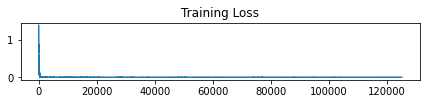

In [71]:
fig = plt.figure()
ax = fig.add_subplot(411)

# loss graphs
fig.tight_layout(pad=0.1) 
ax.clear()
ax.title.set_text("Training Loss")
ax.plot(train_losses)
        
fig.canvas.draw() 

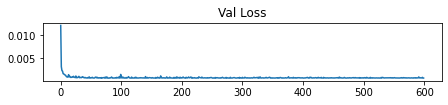

In [72]:
fig = plt.figure()
ax1 = fig.add_subplot(412) 
fig.tight_layout(pad=0.1)
ax1.clear() 
ax1.title.set_text("Val Loss") 
ax1.plot(val_losses) 
fig.canvas.draw()

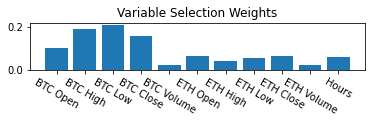

In [73]:
fig = plt.figure() 
ax3 = fig.add_subplot(413)
# visualise variable selection weights 
ax3.title.set_text("Variable Selection Weights") 
plt.xticks(rotation=-30) 
x = ["BTC Open", "BTC High", "BTC Low", "BTC Close", "BTC Volume",
            "ETH Open", "ETH High", "ETH Low", "ETH Close", "ETH Volume", "Hours"] 
ax3.bar(x=x, height=vs_weights) 
fig.canvas.draw()

# Evaluation
N+K Prediction

In [74]:
test_model = TFN(n_var_past_cont = 10,
                 n_var_future_cont = 0, 
                 n_var_past_disc = [24],
                 n_var_future_disc = [24],
                 dim_model = 160)  

test_model.cuda() 
test_model.eval() # to eval mode

TFN(
  (vs_past): VSN(
    (fc): Linear(in_features=1, out_features=160, bias=False)
    (input_grn): GRN(
      (fc1): Linear(in_features=160, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=160, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=160, out_features=160, bias=True)
        (fc2): Linear(in_features=160, out_features=160, bias=True)
      )
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (vs_grn): GRN(
      (skip): Linear(in_features=1760, out_features=11, bias=True)
      (fc1): Linear(in_features=1760, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=11, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=11, out_features=11, bias=True)
        (fc2): Linear(in_features=11, out_features=11, bias=True)
      )
      (norm): LayerNorm((11,), eps=1e-05, elementwise_aff

In [75]:
checkpoint = torch.load("TFT_binance_prototype.pt") 
test_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [175]:
cont_ins, disc_ins = [], [] 
cont_targets, disc_targets = [], [] 

for i in range(100,106): 
    cont_ins.append(full_val[con_cols].values[i:i+N])  
    disc_ins.append(full_val[disc_cols].values[i:i+N]) 
    
    cont_targets.append(full_val[con_cols].values[i+N+K]) 
    disc_targets.append(full_val[disc_cols].values[i+N+K]) 
    
    

In [176]:
cont_ins = torch.tensor(cont_ins, dtype=torch.float32) 
cont_ins = torch.reshape(cont_ins, (K, N, 10, 1))

cont_targets = torch.tensor(cont_targets, dtype=torch.float32) 
cont_targets = torch.reshape(cont_targets, (K,1,10,1)) 

disc_ins = torch.tensor(disc_ins, dtype=torch.float32) 
disc_ins = one_hot(disc_ins, dims=[24]) 
disc_ins = disc_ins[0] 
disc_ins.shape

100%|██████████| 1/1 [00:00<00:00, 1501.72it/s]


torch.Size([6, 30, 24])

In [177]:
disc_ins = torch.reshape(disc_ins, (-1,30,1,24)) 

disc_targets = torch.tensor(disc_targets, dtype=torch.float32) 
disc_targets = torch.reshape(disc_targets, (-1,1,1))
disc_targets = one_hot(disc_targets, dims=[24]) 
disc_targets = disc_targets[0] 
disc_targets = torch.reshape(disc_targets, (-1,1,1,24))  

disc_targets.shape

100%|██████████| 1/1 [00:00<00:00, 1416.52it/s]


torch.Size([6, 1, 1, 24])

In [178]:
cont_ins.shape, disc_ins.shape, cont_targets.shape, disc_targets.shape

(torch.Size([6, 30, 10, 1]),
 torch.Size([6, 30, 1, 24]),
 torch.Size([6, 1, 10, 1]),
 torch.Size([6, 1, 1, 24]))

In [179]:
cont_ins = cont_ins.to(device)
disc_ins = disc_ins.to(device)
cont_targets = cont_targets.to(device) 
disc_targets = disc_targets.to(device) 

In [180]:
test_model.reset(batch_size=cont_ins.shape[0], gpu=True)
net_out, vs_weights = test_model(x_past_cont = cont_ins, 
                                 x_past_disc = disc_ins, 
                                 x_future_cont = None, 
                                 x_future_disc = disc_targets) 

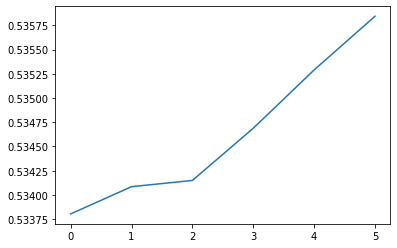

In [181]:
result = net_out.detach().cpu().numpy()

result_flat = [] 
for x in result: 
    result_flat.append(x.item()) 
    
plt.plot(result_flat)


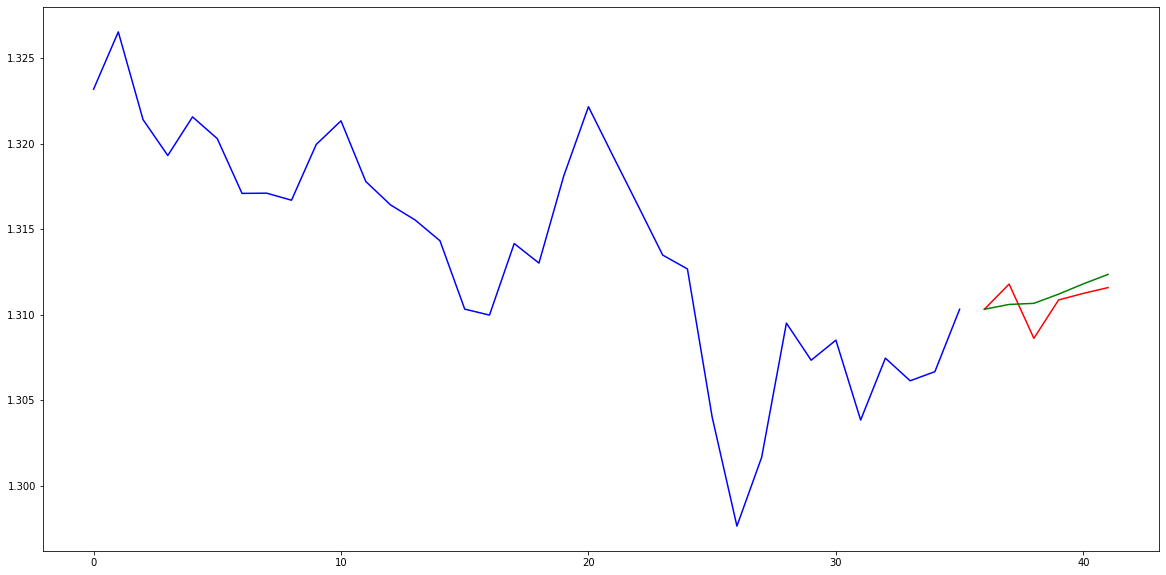

In [184]:
input_sequence = full_val[con_cols].values[100:136, 3]
target_sequence = full_val[con_cols].values[136:142, 3]


diff = -1
if input_sequence[-1] > result_flat[0]: 
    diff = input_sequence[-1] - result_flat[0] 
    result_flat += diff 
elif input_sequence[-1] < result_flat[0]: 
    diff = result_flat[0] - input_sequence[-1] 
    result_flat -= diff


target_diff = -1
if input_sequence[-1] > target_sequence[0]: 
    target_diff = input_sequence[-1] - target_sequence[0] 
    target_sequence += target_diff 
elif input_sequence[-1] < target_sequence[0]: 
    target_diff = target_sequence[0] - input_sequence[-1] 
    target_sequence -= target_diff
    
    


plt.figure(figsize=(20,10))
plt.plot(input_sequence, label = "input_series", color="blue") 
plt.plot(np.arange(N+K, N+K+K), target_sequence, label="target_sequence", color="red")
plt.plot(np.arange(N+K, N+K+K), result_flat, label='predicted', color='green')